In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

DATA_PATH = "C:\\Users\\aisha\\OneDrive\\Desktop\\GitHub\\neural-pricer\\data\\raw\\training_data_phoenix.npz"

In [4]:
data = np.load(DATA_PATH)
X = data["X"]
y = data["y"]

columns = [
    "S0", "r", "sigma", "T",
    "autocall_barrier", "coupon_barrier",
    "coupon_rate", "knock_in_barrier"
]

df = pd.DataFrame(X, columns=columns)
df["price"] = y

print(f"Loaded dataset: {df.shape}")
df.head()

Loaded dataset: (10000, 9)


S0         r     sigma         T  autocall_barrier  coupon_barrier  \
0  118.389061  0.046481  0.179094  0.775878          1.030684        0.827090   
1   84.751910  0.032913  0.210457  0.737538          1.123123        0.750339   
2  113.779807  0.009732  0.241347  1.522020          1.019078        0.980787   
3   95.311860  0.034822  0.109176  0.528022          1.082841        0.805805   
4   98.357434  0.012430  0.161806  1.632651          1.067773        0.648883   

   coupon_rate  knock_in_barrier     price  
0     0.031800          0.885806  0.714575  
1     0.041849          0.560143  0.776074  
2     0.042126          0.887080  0.671924  
3     0.032218          0.665570  0.768437  
4     0.018780          0.542521  0.721190

In [5]:
display(df.describe().T)

print("\n--- Target Variable ---")
print(f"Mean price: {df['price'].mean():.4f}")
print(f"Std dev: {df['price'].std():.4f}")
print(f"Min/Max: {df['price'].min():.4f} / {df['price'].max():.4f}")

count        mean        std        min        25%  \
S0                10000.0  100.201848  11.557504  80.002191  90.142559   
r                 10000.0    0.025015   0.014463   0.000006   0.012738   
sigma             10000.0    0.225767   0.071579   0.100034   0.164048   
T                 10000.0    1.240735   0.435499   0.500122   0.859733   
autocall_barrier  10000.0    1.074727   0.043192   1.000016   1.037316   
coupon_barrier    10000.0    0.800379   0.114900   0.600014   0.702007   
coupon_rate       10000.0    0.027628   0.013067   0.005004   0.016248   
knock_in_barrier  10000.0    0.698188   0.115766   0.500025   0.596927   
price             10000.0    0.705271   0.033191   0.615631   0.681672   

                         50%         75%         max  
S0                100.351148  110.286689  119.999473  
r                   0.024957    0.037489    0.049997  
sigma               0.226060    0.287320    0.349982  
T                   1.235961    1.619053    1.999922  
autocall_barrier    1.074627    1.112005    1.149984  
coupon_barrier      0.799800    0.899660    0.999994  
coupon_rate         0.027525    0.039129    0.049997  
knock_in_barrier    0.697486    0.797820    0.899997  
price               0.702689    0.726905    0.818162


--- Target Variable ---
Mean price: 0.7053
Std dev: 0.0332
Min/Max: 0.6156 / 0.8182


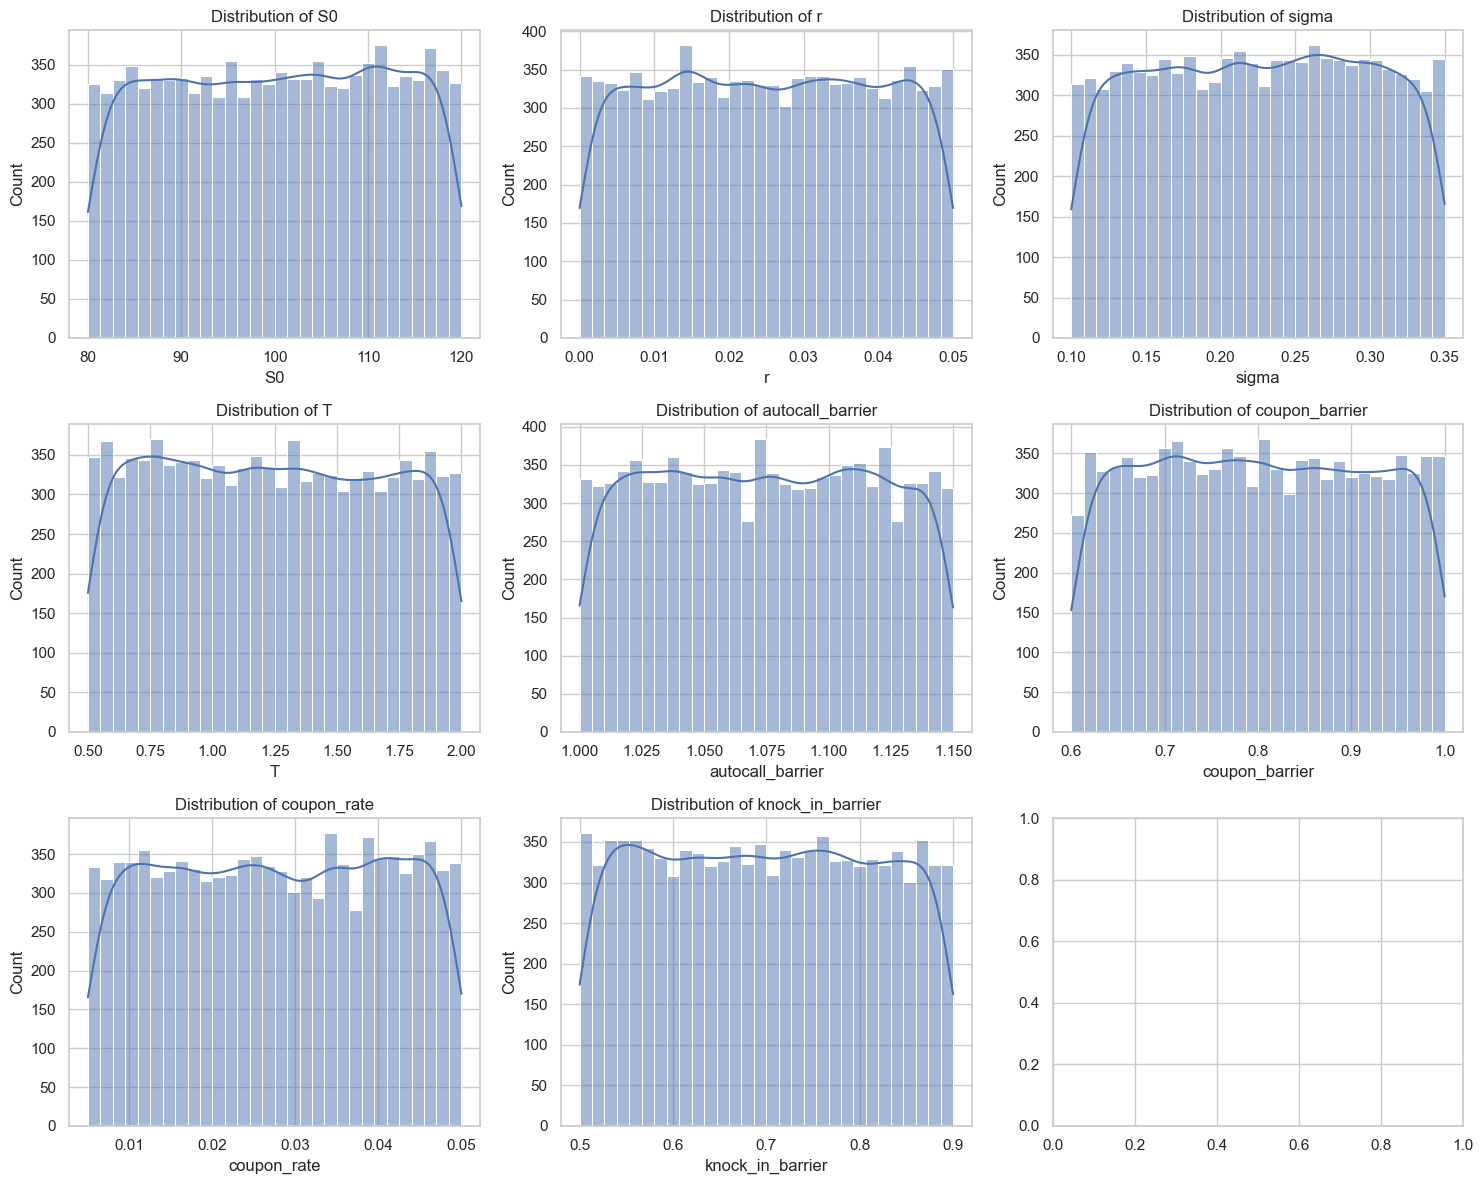

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

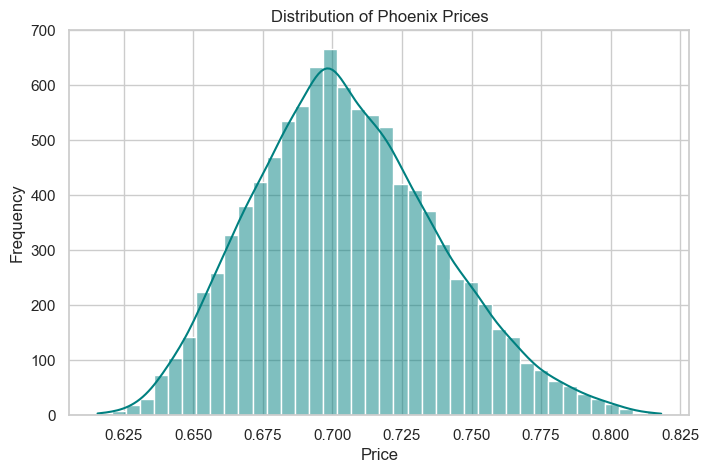

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df["price"], bins=40, kde=True, color="teal")
plt.title("Distribution of Phoenix Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

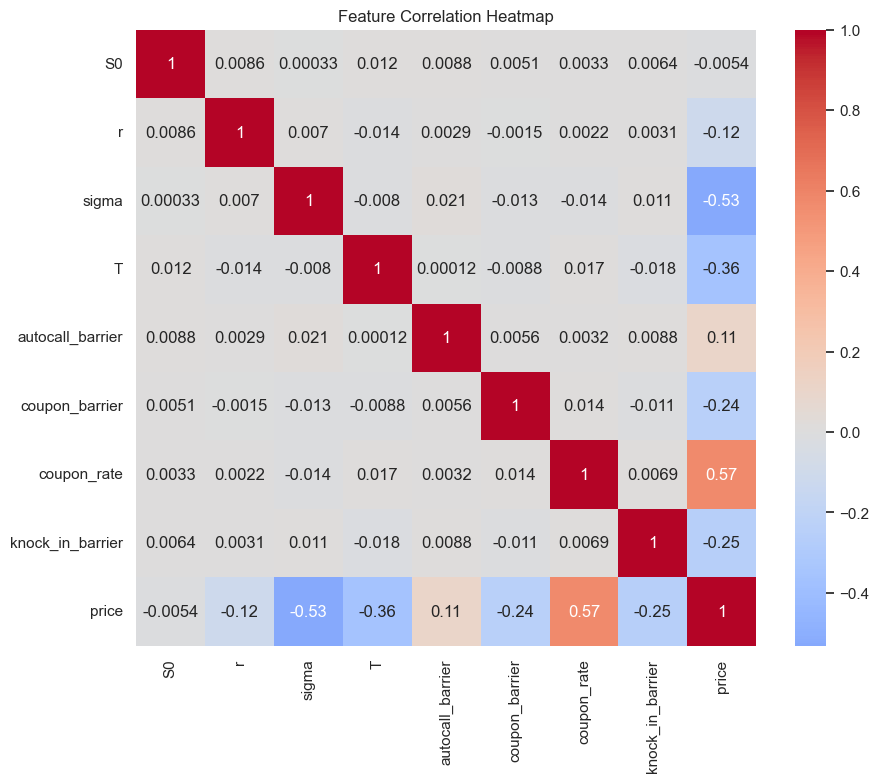

In [8]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

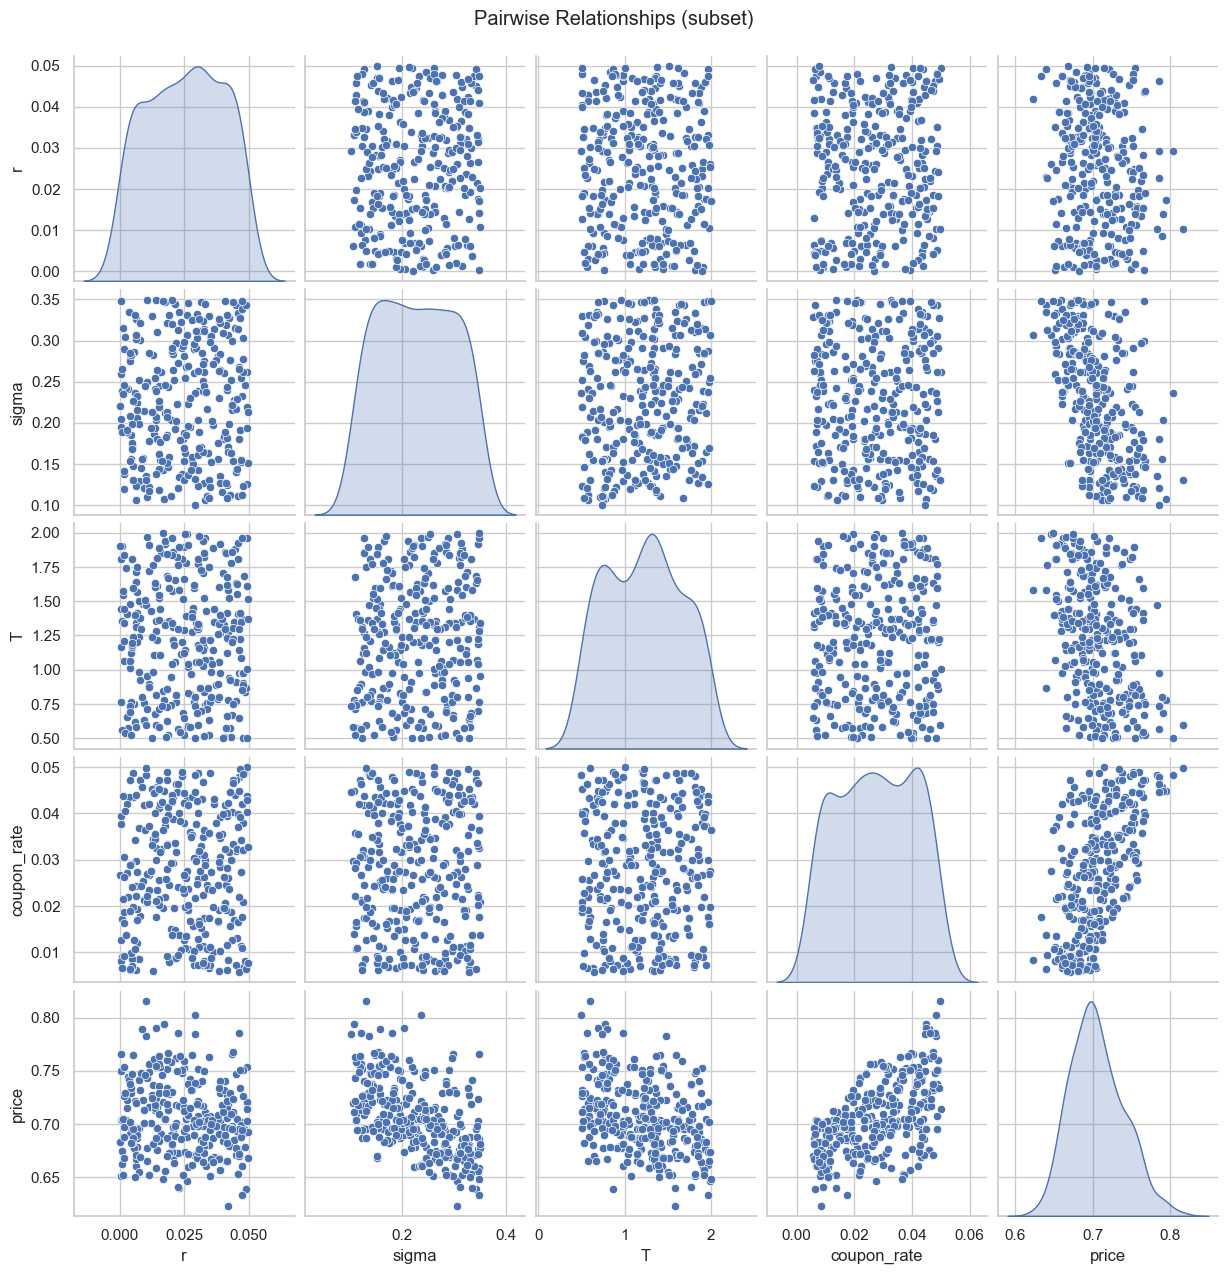

In [9]:
sampled_df = df.sample(n=min(300, len(df)), random_state=42)
sns.pairplot(sampled_df, vars=["r", "sigma", "T", "coupon_rate", "price"], diag_kind="kde")
plt.suptitle("Pairwise Relationships (subset)", y=1.02)
plt.show()

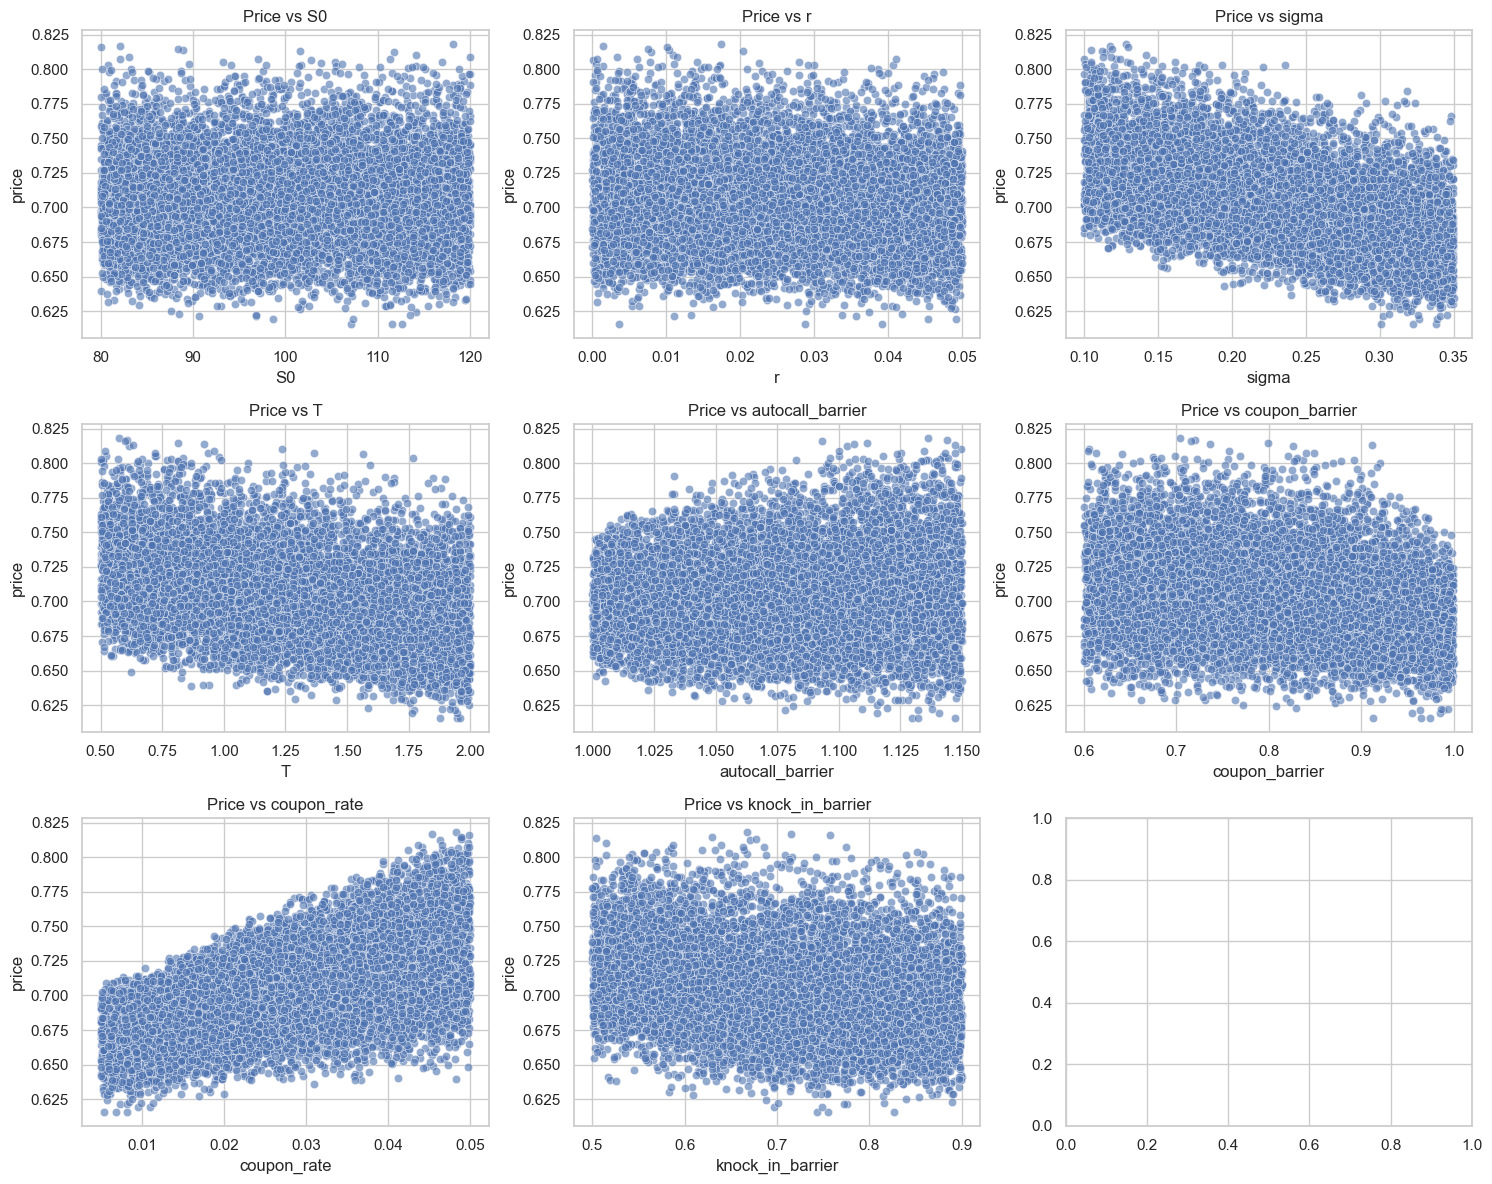

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):
    sns.scatterplot(x=df[col], y=df["price"], ax=axes[i], alpha=0.6)
    axes[i].set_title(f"Price vs {col}")

plt.tight_layout()
plt.show()

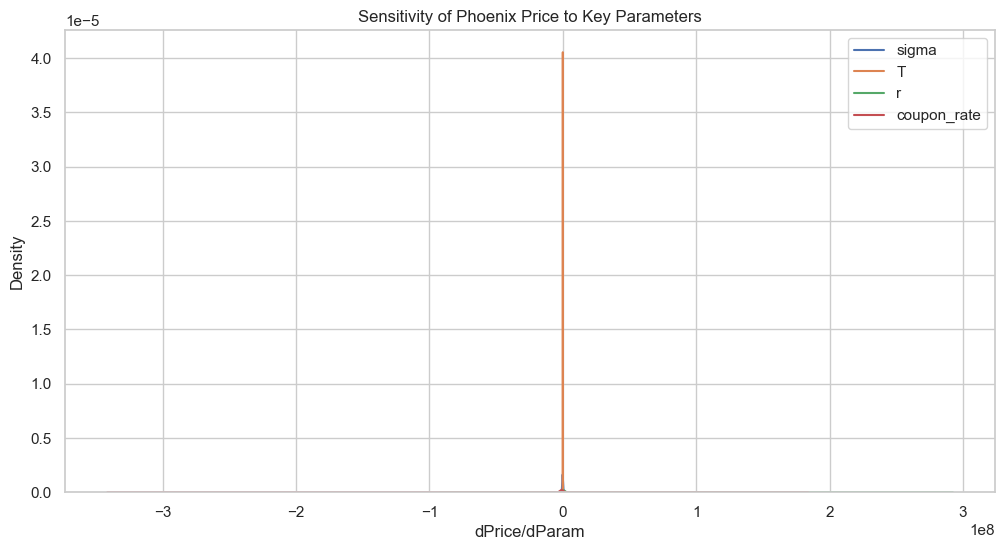

In [11]:
# Sort by feature, take finite differences
def sensitivity(df, feature):
    df_sorted = df.sort_values(feature)
    diff_x = np.diff(df_sorted[feature])
    diff_y = np.diff(df_sorted["price"])
    grad = diff_y / np.where(diff_x == 0, np.nan, diff_x)
    return pd.Series(grad, name=f"dPrice/d{feature}")

plt.figure(figsize=(12,6))
for feature in ["sigma", "T", "r", "coupon_rate"]:
    grad = sensitivity(df, feature)
    sns.kdeplot(grad.dropna(), label=feature)
plt.title("Sensitivity of Phoenix Price to Key Parameters")
plt.xlabel("dPrice/dParam")
plt.legend()
plt.show()

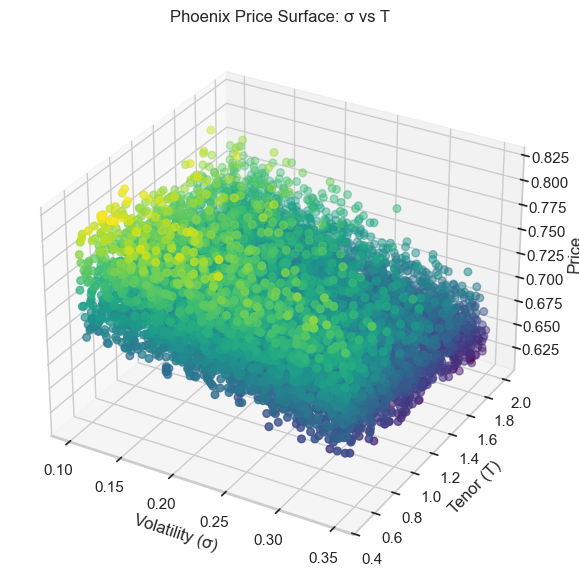

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df["sigma"], df["T"], df["price"], c=df["price"], cmap="viridis", s=30)
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Tenor (T)")
ax.set_zlabel("Price")
ax.set_title("Phoenix Price Surface: σ vs T")
plt.show()

In [13]:
out_path = "../data/processed/phoenix_eda_summary.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df.describe().to_csv(out_path)
print(f"Summary stats saved to {out_path}")

Summary stats saved to ../data/processed/phoenix_eda_summary.csv


In [ ]:
def simulate_gbm_paths(s0, r, sigma, T, n_steps, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / n_steps
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    increments = drift + diffusion * np.random.randn(n_paths, n_steps)
    log_paths = np.zeros((n_paths, n_steps + 1))
    log_paths[:, 0] = np.log(s0)
    log_paths[:, 1:] = np.log(s0) + np.cumsum(increments, axis=1)
    return np.exp(log_paths)

S0 = 100.0
r = 0.03
sigma = 0.2
T = 1.0
n_steps = 252
n_paths = 20

paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths)
times = np.linspace(0, T, paths.shape[1])

print(f"Simulated {n_paths} paths with {paths.shape[1]} time points each.")

Simulated 20 paths with 253 time points each.


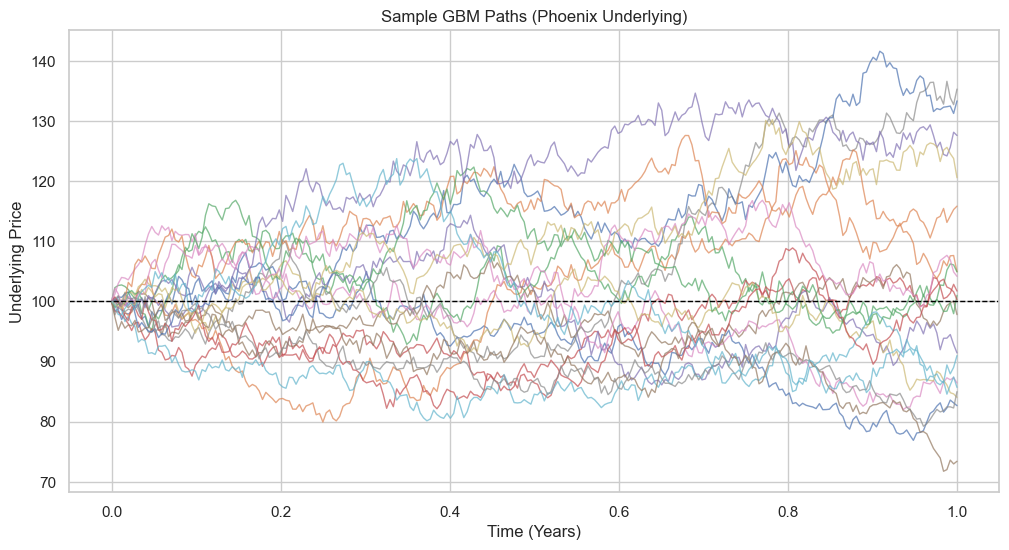

In [15]:
plt.figure(figsize=(12,6))
for i in range(n_paths):
    plt.plot(times, paths[i], lw=1, alpha=0.7)
plt.axhline(S0, color="black", linestyle="--", lw=1)
plt.title("Sample GBM Paths (Phoenix Underlying)")
plt.xlabel("Time (Years)")
plt.ylabel("Underlying Price")
plt.show()

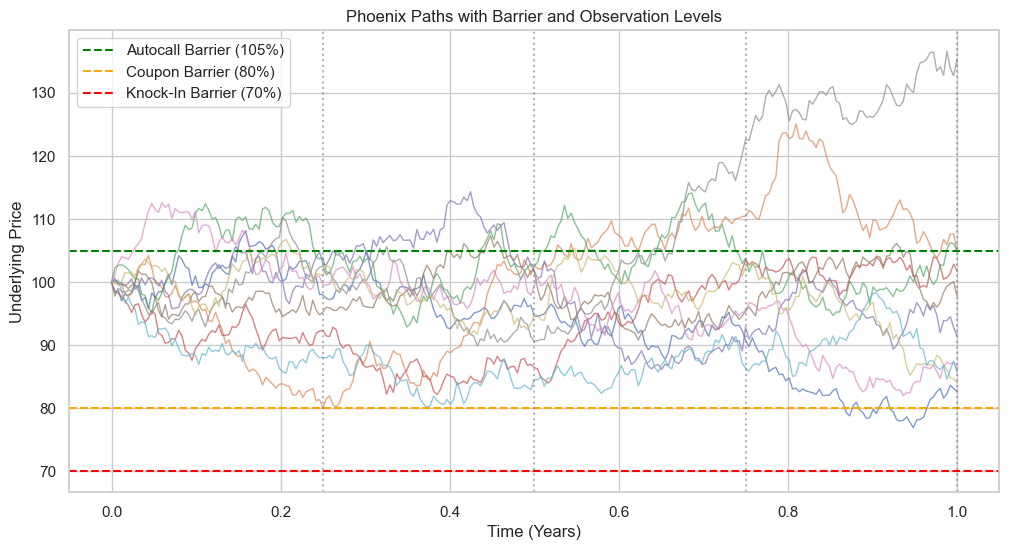

In [ ]:
autocall_barrier = 1.05 * S0   # 105% of spot
knockin_barrier = 0.7 * S0     # 70% of spot
coupon_barrier = 0.8 * S0      # 80% of spot

obs_dates = np.linspace(0, T, 5)[1:]  # exclude t=0

plt.figure(figsize=(12,6))
for i in range(10):
    plt.plot(times, paths[i], lw=1, alpha=0.7)

# Barriers
plt.axhline(autocall_barrier, color="green", linestyle="--", label="Autocall Barrier (105%)")
plt.axhline(coupon_barrier, color="orange", linestyle="--", label="Coupon Barrier (80%)")
plt.axhline(knockin_barrier, color="red", linestyle="--", label="Knock-In Barrier (70%)")

# Observation markers
for t in obs_dates:
    plt.axvline(t, color="gray", linestyle=":", alpha=0.6)

plt.title("Phoenix Paths with Barrier and Observation Levels")
plt.xlabel("Time (Years)")
plt.ylabel("Underlying Price")
plt.legend()
plt.show()

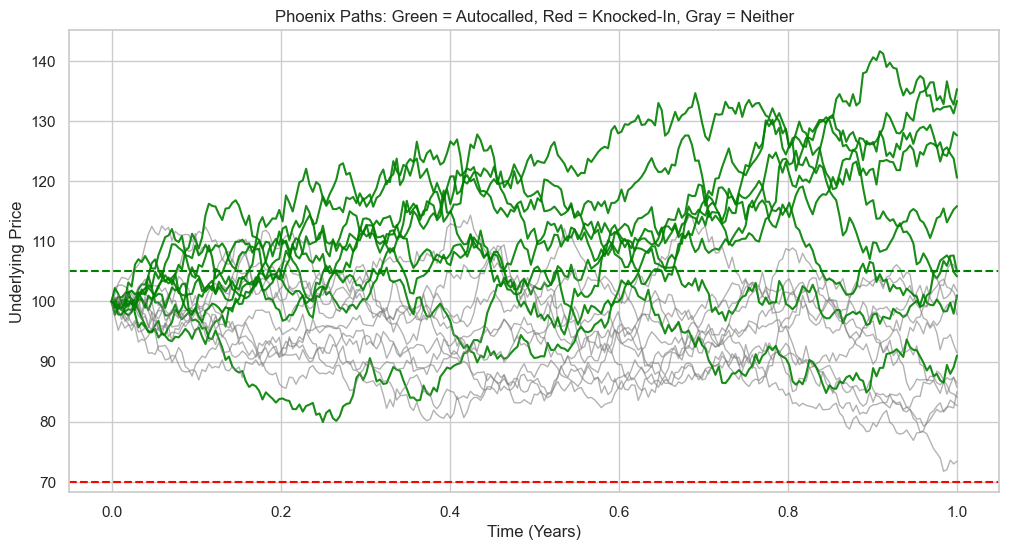

In [ ]:
def detect_events(path, autocall_b, knockin_b, obs_idx):
    call_time = None
    knocked_in = np.any(path < knockin_b)
    for idx in obs_idx:
        if path[idx] >= autocall_b:
            call_time = idx
            break
    return call_time, knocked_in

obs_idx = [int(t * n_steps / T) for t in obs_dates]
call_colors = []

plt.figure(figsize=(12,6))
for i in range(20):
    call_time, knocked_in = detect_events(paths[i], autocall_barrier, knockin_barrier, obs_idx)
    if call_time is not None:
        plt.plot(times, paths[i], lw=1.5, alpha=0.9, color="green")
    elif knocked_in:
        plt.plot(times, paths[i], lw=1.2, alpha=0.9, color="red")
    else:
        plt.plot(times, paths[i], lw=1.0, alpha=0.6, color="gray")

plt.axhline(autocall_barrier, color="green", linestyle="--")
plt.axhline(knockin_barrier, color="red", linestyle="--")
plt.title("Phoenix Paths: Green = Autocalled, Red = Knocked-In, Gray = Neither")
plt.xlabel("Time (Years)")
plt.ylabel("Underlying Price")
plt.show()

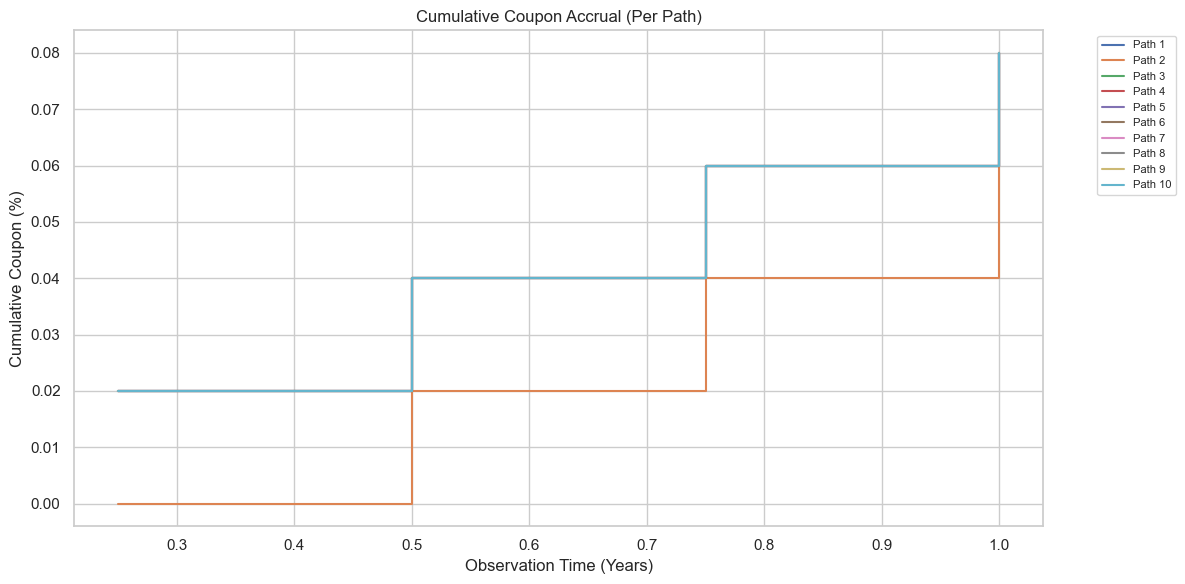

In [18]:
coupon_rate = 0.02  # 2% per quarter

plt.figure(figsize=(12,6))
for i in range(10):
    path = paths[i]
    coupons = 0
    coupon_timeline = []

    for idx in obs_idx:
        if path[idx] >= coupon_barrier:
            coupons += coupon_rate
        coupon_timeline.append(coupons)

    plt.step(obs_dates, coupon_timeline, where="post", label=f"Path {i+1}")

plt.title("Cumulative Coupon Accrual (Per Path)")
plt.xlabel("Observation Time (Years)")
plt.ylabel("Cumulative Coupon (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=8)
plt.tight_layout()
plt.show()


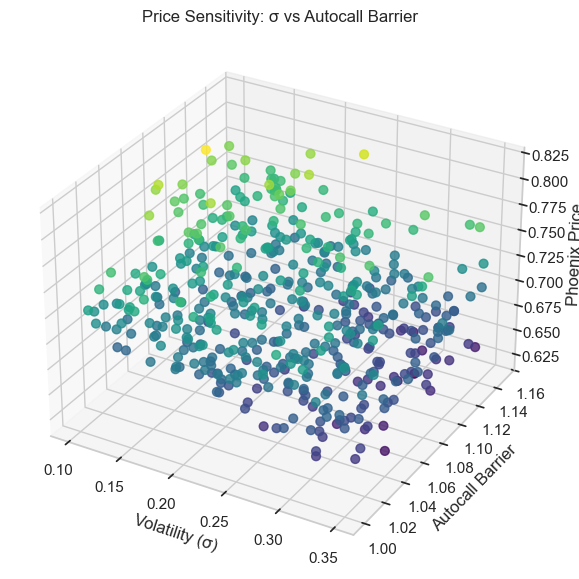

In [19]:
import random
from mpl_toolkits.mplot3d import Axes3D

# Randomly sample
sample_df = df.sample(n=min(500, len(df)), random_state=42)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(sample_df["sigma"], sample_df["autocall_barrier"], sample_df["price"],
           c=sample_df["price"], cmap="viridis", s=40, alpha=0.8)
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Autocall Barrier")
ax.set_zlabel("Phoenix Price")
ax.set_title("Price Sensitivity: σ vs Autocall Barrier")
plt.show()

In [20]:
summary_path = "../data/processed/phoenix_eda_visual_summary.txt"

with open(summary_path, "w") as f:
    f.write("Phoenix EDA Summary\n")
    f.write("=====================\n\n")
    f.write(f"Dataset size: {len(df)}\n")
    f.write(f"Mean price: {df['price'].mean():.4f}\n")
    f.write(f"Std dev: {df['price'].std():.4f}\n\n")
    f.write("Correlation with target:\n")
    corr_target = df.corr()["price"].sort_values(ascending=False)
    f.write(corr_target.to_string())
    f.write("\n\nTop 3 influential parameters (correlation):\n")
    f.write(corr_target.head(4).to_string())

print(f"summary saved to {summary_path}")


summary saved to ../data/processed/phoenix_eda_visual_summary.txt
